In [2]:
import torch
#import torchtext
#from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, PackedSequence
from torch import nn

from torch import Tensor, dot, matmul

import torch.nn.functional as F

## **Basic Example**

In [5]:
seq = torch.FloatTensor([[26, 27, 31]])  

In [6]:
seq

tensor([[26., 27., 31.]])

In [9]:
# Defining a basic RNN layer
rnn= nn.RNN(input_size=1, hidden_size=1, num_layers = 1, bias = False, batch_first=True)

RNN expects input sequences to be in a particular format. By setting batch_first = True, we set the input data format to be 'batch size, sequence length, # input features'

In [7]:
seq = seq.unsqueeze(2)
print(seq.shape)

print(seq)

torch.Size([1, 3, 1])
tensor([[[26.],
         [27.],
         [31.]]])


With the correct input format, we can now pass the input to the RNN layer. The RNN layer provides 2 outputs


1.   All hidden states associated with a sequence, for all sequences in the batch
2.   Just the very last hidden state for a sequence, for all sequences in the batch



In [10]:
out_all,out_last = rnn(seq)

In [11]:
#print(out_all)
print(out_last)

tensor([[[-0.8136]]], grad_fn=<StackBackward0>)


In [11]:
print(f"Out all shape : {out_all.shape}")

print(f"Out last shape : {out_last.shape}")


Out all shape : torch.Size([1, 3, 1])
Out last shape : torch.Size([1, 1, 1])


There are 2 ways that we can acess the weights of the RNN layer.

1.   Accessing individual parameters using their names `weight_hh_10`, `weight_1h_10` and so on.
2.   Using the `state_dict()` parameter to access all weights





In [12]:
rnn.weight_hh_l0

Parameter containing:
tensor([[-0.5275]], requires_grad=True)

In [13]:
rnn.weight_ih_l0

Parameter containing:
tensor([[-0.7317]], requires_grad=True)

In [14]:
rnn.state_dict()

OrderedDict([('weight_ih_l0', tensor([[-0.7317]])),
             ('weight_hh_l0', tensor([[0.2446]]))])

### **Computing the output**

RNN layers essentially take in a sequence and compute outputs for each time point in the input sequence. The weights that are used for computation remain the same for all time points.

The basic equation governing the computation is given by :
$h_t = \text{tanh}(W_{ih} x_t + b_{ih} + W_{hh} h_{(t-1)} + b_{hh})$

where 
$h_{t}$ represents the hidden state at time $t$








In [ ]:
# Output states computed by the RNN layer
out_all

#### Hidden State 1

Note. Since this is the very first state (time = 1) and we dont have a hidden state preceding it, we assumne it be zero. Therefore, $h_{0}$ is taken to be 0.

In [15]:
wih = rnn.weight_ih_l0
whh = rnn.weight_hh_l0

x = seq[0][0] # The first input feature of the first sequence

# Computing thw hidden state for time = 1
h1 = torch.tanh(Tensor(x*wih + whh*0))  
h1

tensor([[-0.9755]], grad_fn=<TanhBackward0>)

#### Hidden State 2

In [16]:
x = seq[0][1] # The second input feature of the first sequence

h2 = torch.tanh(Tensor(x*wih + whh*h1))  
h2

tensor([[-0.9964]], grad_fn=<TanhBackward0>)

#### Hidden State 3

In [17]:
x = seq[0][2] # The third and last input feature of the first sequence

h3 = torch.tanh(Tensor(x*wih + whh*h2))  
h3

tensor([[-0.9992]], grad_fn=<TanhBackward0>)

We can observe that :


1.   RNN does a very basic computation repeatedly on all features of the given sequence
2.   The output at a particular time stamp depends on the outputs at a previous time stamp



## **Adding more features**

We increase the complexity of the RNN computation by increasing the number of features at each sequence time stamp. Previously, each time stamp was represented by a single value. Now, we expand that to be represented by a feature vector

In [19]:
seq = Tensor([[23,97,1.3],[25,85,1.4],[30,57,1.7], [29,87,1.1]])

seq = seq.unsqueeze(0)

seq.shape

torch.Size([1, 4, 3])

In [20]:
seq

tensor([[[23.0000, 97.0000,  1.3000],
         [25.0000, 85.0000,  1.4000],
         [30.0000, 57.0000,  1.7000],
         [29.0000, 87.0000,  1.1000]]])

The `seq` variable represents a sequence of length 4, where each element (time-stamp) is represented by a feature vector of length 3.

We next define a RNN layer where we set `input_size` to be 3. This time, we also set `bias` to be True, so that we include a bias term in our calculations

In [17]:
# Defining a basic RNN layer
rnn= nn.RNN(input_size=3, hidden_size=1, num_layers = 1, bias = True, batch_first=True)

In [18]:
out_all, out_last = rnn(seq)

#print(f"Out all shape : {out_all.shape}")

print(f"Out last shape : {out_last.shape}")

Out last shape : torch.Size([1, 1, 1])


### **Computing outputs**

In [24]:
out_all

tensor([[[ 0.1439],
         [-0.0213],
         [ 0.7185],
         [-0.5435]]], grad_fn=<TransposeBackward1>)

#### Hidden State 1

A minor modification compared to the previous code is that we will be using dot multiplication to multiply $x$ with $W_{ih}$ and $h_{t-1}$ with $W_{hh}$.

In [28]:
seq[0][0]

tensor([1., 1., 1.])

In [29]:
wih = rnn.weight_ih_l0.squeeze(0)
whh = rnn.weight_hh_l0.squeeze(0)

bih = rnn.bias_ih_l0
bhh = rnn.bias_hh_l0

x = seq[0][0] # The first input feature of the first sequence

# Computing thw hidden state for time = 1
h1 = torch.tanh(Tensor(dot(x,wih) + bih  + dot(whh,Tensor([0.0])) + bhh))  
h1

tensor([0.1439], grad_fn=<TanhBackward0>)

In [35]:
whh

tensor([-0.9790], grad_fn=<SqueezeBackward1>)

#### Hidden State 2

In [37]:
x = seq[0][1] # The first input feature of the first sequence

# Computing thw hidden state for time = 1
h2 = torch.tanh(Tensor(dot(x,wih) + bih  + dot(h1,whh) + bhh))  
h2

tensor([-0.0213], grad_fn=<TanhBackward0>)

#### Computing all states

We automate the manual computation of hidden states to verify our computation matches with the RNN layer output

In [38]:
output = []

h_previous = Tensor([0.0])

for i in range(seq.shape[1]):

  if i == 0:
    x = seq[0][i]
    h_current = torch.tanh(Tensor(dot(x,wih) + bih  + dot(h_previous,whh) + bhh))
    h_previous = h_current
    output.append(h_current.detach().numpy())

  else:
    x = seq[0][i]
    h_current = torch.tanh(Tensor(dot(x,wih) + bih  + dot(h_previous,whh) + bhh))
    h_previous = h_current
    output.append(h_current.detach().numpy())



In [39]:
output

[array([0.14390633], dtype=float32),
 array([-0.02130448], dtype=float32),
 array([0.718476], dtype=float32),
 array([-0.54353434], dtype=float32)]

## **Increasing Hidden Size**

Till now, we had `hidden_size` parameter fixed at 1. We increase this value and see how it affects the RNN computation

In [40]:
# Defining the RNN layer
rnn= nn.RNN(input_size=3, hidden_size=2, num_layers = 1, bias = True, batch_first=True)

In [41]:
out_all, out_last = rnn(seq)

print(f"Out all shape : {out_all.shape}")

print(f"Out last shape : {out_last.shape}")

Out all shape : torch.Size([1, 4, 2])
Out last shape : torch.Size([1, 1, 2])


We can see from the output shape that the size of the hidden states has increased to 2, corresponding to the increase in the `hidden_size` parameter to 2

In [42]:
rnn.state_dict()

OrderedDict([('weight_ih_l0',
              tensor([[ 0.2481, -0.2421,  0.3777],
                      [ 0.1484, -0.4255,  0.4699]])),
             ('weight_hh_l0',
              tensor([[-0.2449,  0.1648],
                      [-0.6750,  0.1895]])),
             ('bias_ih_l0', tensor([-0.4573,  0.4712])),
             ('bias_hh_l0', tensor([ 0.4291, -0.6638]))])

Similarly, the RNN layer weight shapes have also changed in response to the new `hidden_size` parameter value

### **Computing outputs**

On increasing the `hidden_size` parameter to 2, we are essentially increase the size of the hidden states computed for each time-stamp. This essentially allows the hidden states to be more expressive and store more information.

In [ ]:
out_all

#### Hidden State 1

In [ ]:
wih = rnn.weight_ih_l0
whh = rnn.weight_hh_l0

bih = rnn.bias_ih_l0
bhh = rnn.bias_hh_l0

x = seq[0][0] # The first input feature of the first sequence

# Computing thw hidden state for time = 1
h1 = torch.tanh(Tensor(matmul(x,wih.T) + bih  + matmul( torch.zeros([1,2]) , whh.T ) + bhh))  
h1

#### Computing for all states

In [0]:
output = []

h_previous = torch.zeros([1,2])  # Since the hidden_size parameter is 2, all hidden states will have a shape of [1,2]

for i in range(seq.shape[1]):

  x = seq[0][i]
  h_current = torch.tanh(Tensor(matmul(x,wih.T) + bih  + matmul(h_previous,whh.T) + bhh))
  h_previous = h_current
  output.append(h_current)




In [ ]:
output

## **Stacked RNNs**

In [0]:
# Defining the RNN layer
rnn= nn.RNN(input_size=3, hidden_size=3, num_layers = 2, bias = True, batch_first=True, bidirectional=False)

In [ ]:
out_all, out_last = rnn(seq)

print(f"Out all shape : {out_all.shape}")

print(f"Out last shape : {out_last.shape}")

In [ ]:
out_all

In [ ]:
out_last

In [ ]:
rnn.state_dict()

### **Computing Outputs - Layer 1**

In [ ]:
# Extracting the weights for RNN Layer 1
wih_10 = rnn.weight_ih_l0
whh_10 = rnn.weight_hh_l0

bih_10 = rnn.bias_ih_l0
bhh_10 = rnn.bias_hh_l0

output_1 = []

h_previous = torch.zeros([1,3])  # Since the hidden_size parameter is 3, all hidden states will have a shape of [1,3]

for i in range(seq.shape[1]):

  x = seq[0][i]
  h_current = torch.tanh(Tensor(matmul(x,wih_10.T) + bih_10  + matmul(h_previous,whh_10.T) + bhh_10))
  h_previous = h_current
  output_1.append(h_current)

output_1

### **Computing Outputs - Layer 2**

In [ ]:
# Extracting the weights for RNN Layer 1
wih_11 = rnn.weight_ih_l1
whh_11 = rnn.weight_hh_l1

bih_11 = rnn.bias_ih_l1
bhh_11 = rnn.bias_hh_l1

output_2 = []

h_previous = torch.zeros([1,3]) # Since the hidden_size parameter is 2, all hidden states will have a shape of [1,2]

for i in range(seq.shape[1]):
  
  x = seq[0][i]
  h_current = torch.tanh(Tensor(matmul(output_1[i],wih_11.T) + bih_11  + matmul(h_previous,whh_11.T) + bhh_11))
  h_previous = h_current
  output_2.append(h_current)

output_2

In [ ]:
out_all

In [ ]:
out_last

## **Expanding to GRUs**

In [43]:
# Defining a basic GRU layer
gru = nn.GRU(input_size=3, hidden_size=1, num_layers = 1, bias = True, batch_first=True)

\begin{array}{ll}
 |          r_t = \sigma(W_{ir} x_t + b_{ir} + W_{hr} h_{(t-1)} + b_{hr}) \\
 |          z_t = \sigma(W_{iz} x_t + b_{iz} + W_{hz} h_{(t-1)} + b_{hz}) \\
 |          n_t = \tanh(W_{in} x_t + b_{in} + r_t * (W_{hn} h_{(t-1)}+ b_{hn})) \\
 |          h_t = (1 - z_t) * n_t + z_t * h_{(t-1)}
 |      \end{array}

In [44]:
gru.state_dict()

OrderedDict([('weight_ih_l0',
              tensor([[-0.3176, -0.1480,  0.4737],
                      [ 0.4395,  0.5387,  0.0475],
                      [ 0.0298, -0.4959,  0.3168]])),
             ('weight_hh_l0',
              tensor([[ 0.9766],
                      [-0.5660],
                      [-0.0268]])),
             ('bias_ih_l0', tensor([0.8314, 0.6171, 0.1580])),
             ('bias_hh_l0', tensor([ 0.2155, -0.8791, -0.3222]))])

In [45]:
out_all, out_last = gru(seq)

print(f"Out all shape : {out_all.shape}")

print(f"Out last shape : {out_last.shape}")

Out all shape : torch.Size([1, 4, 1])
Out last shape : torch.Size([1, 1, 1])


### Extracting layer weights

In [47]:
wir_10 = gru.weight_ih_l0[0,:].squeeze(0)
wiz_10 = gru.weight_ih_l0[1,:].squeeze(0)
win_10 = gru.weight_ih_l0[2,:].squeeze(0)

whr_10 = gru.weight_hh_l0[0]
whz_10 = gru.weight_hh_l0[1]
whn_10 = gru.weight_hh_l0[2]

bir_10 = gru.bias_ih_l0[0]
biz_10 = gru.bias_ih_l0[1]
bin_10 = gru.bias_ih_l0[2]

bhr_10 = gru.bias_hh_l0[0]
bhz_10 = gru.bias_hh_l0[1]
bhn_10 = gru.bias_hh_l0[2]

### **Computing outputs**

#### Hidden State 1

In [ ]:
x = seq[0][0]

h_previous = torch.Tensor([0.0])

r = torch.sigmoid(dot(x,wir_10) + bir_10  + dot(h_previous,whr_10) + bhr_10  )
z = torch.sigmoid(dot(x,wiz_10) + biz_10  + dot(h_previous,whz_10) + bhz_10  )
n = torch.tanh(   dot(x,win_10) + bin_10  + r*( dot(h_previous,whn_10) + bhn_10) )
h1 = (1-z)*n + z*h_previous

h1

#### Hidden State 2

In [ ]:
x = seq[0][1]

h_previous = h1

r = torch.sigmoid(dot(x,wir_10) + bir_10  + dot(h_previous,whr_10) + bhr_10  )
z = torch.sigmoid(dot(x,wiz_10) + biz_10  + dot(h_previous,whz_10) + bhz_10  )
n = torch.tanh(   dot(x,win_10) + bin_10  + r*( dot(h_previous,whn_10) + bhn_10) )
h2 = (1-z)*n + z*h_previous

h2

#### Hidden State 3

In [ ]:
x = seq[0][2]

h_previous = h2

r = torch.sigmoid(dot(x,wir_10) + bir_10  + dot(h_previous,whr_10) + bhr_10  )
z = torch.sigmoid(dot(x,wiz_10) + biz_10  + dot(h_previous,whz_10) + bhz_10  )
n = torch.tanh(   dot(x,win_10) + bin_10  + r*( dot(h_previous,whn_10) + bhn_10) )
h3 = (1-z)*n + z*h_previous

h3

In [ ]:
out_all

## **Extending to LSTMs**

In [48]:
# Defining a basic LSTM layer
lstm = nn.LSTM(input_size=3, hidden_size=1, num_layers = 1, bias = True, batch_first=True)

\begin{array}{ll} \\
 |          i_t = \sigma(W_{ii} x_t + b_{ii} + W_{hi} h_{(t-1)} + b_{hi}) \\
 |          f_t = \sigma(W_{if} x_t + b_{if} + W_{hf} h_{(t-1)} + b_{hf}) \\
 |          g_t = \tanh(W_{ig} x_t + b_{ig} + W_{hg} h_{(t-1)} + b_{hg}) \\
 |          o_t = \sigma(W_{io} x_t + b_{io} + W_{ho} h_{(t-1)} + b_{ho}) \\
 |          c_t = f_t * c_{(t-1)} + i_t * g_t \\
 |          h_t = o_t * \tanh(c_t) \\
 |      \end{array}

In [49]:
lstm.state_dict()

OrderedDict([('weight_ih_l0',
              tensor([[-0.8383, -0.4427,  0.4031],
                      [ 0.6026, -0.1456,  0.4684],
                      [-0.6922,  0.1373,  0.8569],
                      [-0.3388, -0.3505,  0.6243]])),
             ('weight_hh_l0',
              tensor([[ 0.7410],
                      [-0.7611],
                      [-0.8382],
                      [ 0.3467]])),
             ('bias_ih_l0', tensor([-0.2139,  0.7388,  0.6983,  0.3958])),
             ('bias_hh_l0', tensor([ 0.4449, -0.3047,  0.5552, -0.0351]))])

In [50]:
out_all, out_last = lstm(seq)

print(f"Out all shape : {out_all.shape}")

print(f"Out last shape : {out_last[0].shape}")

Out all shape : torch.Size([1, 4, 1])
Out last shape : torch.Size([1, 1, 1])


In [51]:
out_last

(tensor([[[0.1979]]], grad_fn=<StackBackward0>),
 tensor([[[0.5228]]], grad_fn=<StackBackward0>))

In [52]:
out_all

tensor([[[0.1745],
         [0.2268],
         [0.1493],
         [0.1979]]], grad_fn=<TransposeBackward0>)

### Extracting weights

In [0]:
wii_10 = lstm.weight_ih_l0[0,:].squeeze(0)
wif_10 = lstm.weight_ih_l0[1,:].squeeze(0)
wig_10 = lstm.weight_ih_l0[2,:].squeeze(0)
wio_10 = lstm.weight_ih_l0[3,:].squeeze(0)

whi_10 = lstm.weight_hh_l0[0]
whf_10 = lstm.weight_hh_l0[1]
whg_10 = lstm.weight_hh_l0[2]
who_10 = lstm.weight_hh_l0[3]

bii_10 = lstm.bias_ih_l0[0]
bif_10 = lstm.bias_ih_l0[1]
big_10 = lstm.bias_ih_l0[2]
bio_10 = lstm.bias_ih_l0[3]

bhi_10 = lstm.bias_hh_l0[0]
bhf_10 = lstm.bias_hh_l0[1]
bhg_10 = lstm.bias_hh_l0[2]
bho_10 = lstm.bias_hh_l0[3]

## **Computing output**

\begin{array}{ll} \\
 |          i_t = \sigma(W_{ii} x_t + b_{ii} + W_{hi} h_{(t-1)} + b_{hi}) \\
 |          f_t = \sigma(W_{if} x_t + b_{if} + W_{hf} h_{(t-1)} + b_{hf}) \\
 |          g_t = \tanh(W_{ig} x_t + b_{ig} + W_{hg} h_{(t-1)} + b_{hg}) \\
 |          o_t = \sigma(W_{io} x_t + b_{io} + W_{ho} h_{(t-1)} + b_{ho}) \\
 |          c_t = f_t * c_{(t-1)} + i_t * g_t \\
 |          h_t = o_t * \tanh(c_t) \\
 |      \end{array}

In [53]:
help(nn.LSTM)

Help on class LSTM in module torch.nn.modules.rnn:

class LSTM(RNNBase)
 |  LSTM(*args, **kwargs)
 |  
 |  __init__(self,input_size,hidden_size,num_layers=1,bias=True,batch_first=False,dropout=0.0,bidirectional=False,proj_size=0,device=None,dtype=None)
 |  
 |  Apply a multi-layer long short-term memory (LSTM) RNN to an input sequence.
 |  For each element in the input sequence, each layer computes the following
 |  function:
 |  
 |  .. math::
 |      \begin{array}{ll} \\
 |          i_t = \sigma(W_{ii} x_t + b_{ii} + W_{hi} h_{t-1} + b_{hi}) \\
 |          f_t = \sigma(W_{if} x_t + b_{if} + W_{hf} h_{t-1} + b_{hf}) \\
 |          g_t = \tanh(W_{ig} x_t + b_{ig} + W_{hg} h_{t-1} + b_{hg}) \\
 |          o_t = \sigma(W_{io} x_t + b_{io} + W_{ho} h_{t-1} + b_{ho}) \\
 |          c_t = f_t \odot c_{t-1} + i_t \odot g_t \\
 |          h_t = o_t \odot \tanh(c_t) \\
 |      \end{array}
 |  
 |  where :math:`h_t` is the hidden state at time `t`, :math:`c_t` is the cell
 |  state at time `t`,

# Seq2Seq RNN in PyTorch

For a sequence-to-sequence (seq2seq) task, where each input time step maps to an output time step, you'll want your model to produce a sequence of outputs. Here's how you can set that up in PyTorch when the input size and output size are different:

In [54]:
import torch
import torch.nn as nn

class Seq2SeqRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Seq2SeqRNN, self).__init__()
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x: (batch_size, seq_len, input_size)
        rnn_out, _ = self.rnn(x)  # rnn_out: (batch_size, seq_len, hidden_size)
        
        # Apply linear layer to each time step
        output = self.fc(rnn_out)  # output: (batch_size, seq_len, output_size)
        
        return output

# Example usage
batch_size = 16
seq_len = 10
input_size = 8
hidden_size = 20
output_size = 6

model = Seq2SeqRNN(input_size, hidden_size, output_size)
x = torch.randn(batch_size, seq_len, input_size)
y = model(x)

print(y.shape)  # Expected: (16, 10, 6)

torch.Size([16, 10, 6])


# Seq2seq: different sequence length
the output sequence length differs from the input sequence length, you need a true encoder-decoder (seq2seq) architecture. 
1. Encoder
Reads the input sequence of length input_seq_len
Encodes it into a fixed-size context vector (e.g., final hidden state)
2. Decoder
Takes the context vector and generates a sequence of outputs of length output_seq_len, one step at a time

In [56]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Encoder, self).__init__()
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, batch_first=True)

    def forward(self, x):
        # x: (batch_size, input_seq_len, input_size)
        outputs, hidden = self.rnn(x)  # hidden: (1, batch, hidden_size)
        return hidden


class Decoder(nn.Module):
    def __init__(self, output_size, hidden_size):
        super(Decoder, self).__init__()
        self.rnn = nn.RNN(input_size=output_size, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, decoder_input, hidden):
        # decoder_input: (batch_size, 1, output_size) ← one timestep
        output, hidden = self.rnn(decoder_input, hidden)
        output = self.fc(output)  # (batch_size, 1, output_size)
        return output, hidden


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, output_seq_len):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.output_seq_len = output_seq_len

    def forward(self, x):
        batch_size = x.size(0)
        output_size = self.decoder.fc.out_features
        
        hidden = self.encoder(x)

        # Start with zeros or a special <START> token
        decoder_input = torch.zeros(batch_size, 1, output_size, device=x.device)

        outputs = []

        for _ in range(self.output_seq_len):
            output, hidden = self.decoder(decoder_input, hidden)
            outputs.append(output)
            decoder_input = output  # Teacher forcing could go here

        return torch.cat(outputs, dim=1)  # (batch_size, output_seq_len, output_size)

# Example
input_size = 8
hidden_size = 16
output_size = 6

input_seq_len = 10
output_seq_len = 7

encoder = Encoder(input_size, hidden_size)
decoder = Decoder(output_size, hidden_size)
model = Seq2Seq(encoder, decoder, output_seq_len)

x = torch.randn(32, input_seq_len, input_size)
y = model(x)
print(y.shape)  # Expected: (32, 7, 6)


torch.Size([32, 7, 6])


# Work on ETT dataset

In [26]:
import torch
from torch import nn
import pandas as pd

In [27]:
df = pd.read_csv('../Data/ETTH1.csv')
print(df.head())
print(df.shape)
print(df.columns)


                  date   HUFL   HULL   MUFL   MULL   LUFL   LULL         OT
0  2016-07-01 00:00:00  5.827  2.009  1.599  0.462  4.203  1.340  30.531000
1  2016-07-01 01:00:00  5.693  2.076  1.492  0.426  4.142  1.371  27.787001
2  2016-07-01 02:00:00  5.157  1.741  1.279  0.355  3.777  1.218  27.787001
3  2016-07-01 03:00:00  5.090  1.942  1.279  0.391  3.807  1.279  25.044001
4  2016-07-01 04:00:00  5.358  1.942  1.492  0.462  3.868  1.279  21.948000
(17420, 8)
Index(['date', 'HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT'], dtype='object')


In [28]:
df = df.drop('date', axis=1)
df.head()

,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,5.358,1.942,1.492,0.462,3.868,1.279,21.948000


In [30]:
import torch
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, data, input_window, output_window):
        """
        Args:
            data (torch.Tensor or np.array): time series data, shape (time_steps, features) or (time_steps,)
            input_window (int): number of time steps for input
            output_window (int): number of time steps to predict
        """
        if isinstance(data, np.ndarray):
            data = torch.tensor(data, dtype=torch.float32)

        self.data = data
        self.input_window = input_window
        self.output_window = output_window
        self.length = len(data) - input_window - output_window + 1

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        x = self.data[idx : idx + self.input_window]
        y = self.data[idx + self.input_window : idx + self.input_window + self.output_window]
        y = y[:,-1]
        
        return x, y
    

In [34]:
import numpy as np
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler

# Dummy time series data
#time_series = np.sin(np.linspace(0, 100, 500))  # shape: (500,)
data_size = df.shape[0]
df_train = df[0:int(data_size*0.6)]
df_val = df[int(data_size*0.6):int(data_size*0.8)]
df_test = df[int(data_size*0.8):-1]
time_series_train = df_train.to_numpy()
time_series_val = df_val.to_numpy()
time_series_test = df_test.to_numpy()

scaler = StandardScaler()
scaler.fit(time_series_train)
time_series_train = scaler.transform(time_series_train.astype(float))
time_series_val = scaler.transform(time_series_val.astype(float))
time_series_test = scaler.transform(time_series_test.astype(float))
time_series_train = StandardScaler().fit(time_series_train).transform(time_series_train.astype(float))



input_window = 30
output_window = 1

dataset_train = TimeSeriesDataset(time_series_train, input_window, output_window)
dataloader_train = DataLoader(dataset_train, batch_size=32, shuffle=True)

dataset_val = TimeSeriesDataset(time_series_val, input_window, output_window)
dataloader_val = DataLoader(dataset_val, batch_size=32, shuffle=True)

dataset_test = TimeSeriesDataset(time_series_test, input_window, output_window)
dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=True)

# Fetch one batch
#for x_batch, y_batch in dataloader:
#    print("Input batch shape:", x_batch.shape)   # (batch_size, input_window)
#    print("Target batch shape:", y_batch.shape)  # (batch_size, output_window)
#    y_batch = torch.unsqueeze(y_batch,2)
#    print("Target batch shape:", y_batch.shape)
#    #print(y_batch)
#    break

100%|██████████| 40/40 [00:47<00:00,  1.19s/it]

[0.12034782 0.02329946 0.019869   0.01832697 0.01745377 0.01690326
 0.01651902 0.0162567  0.01605937 0.01588678 0.01573124 0.01566087
 0.0155213  0.0154532  0.01538164 0.01533807 0.01527864 0.01526471
 0.01518613 0.01513328 0.01513833 0.01506626 0.01506702 0.01506654
 0.01501291 0.01497261 0.01496673 0.01494162 0.01488809 0.01486762
 0.0149007  0.01481825 0.01482155 0.01482249 0.0147794  0.01479995
 0.01476432 0.01471985 0.01471164 0.01472414]


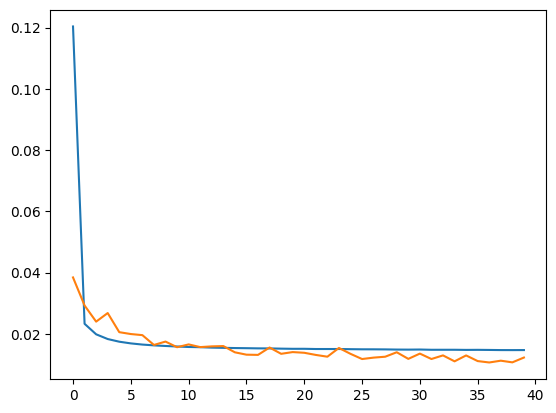

In [35]:
import torch
import torch.nn as nn
from tqdm import tqdm
from matplotlib import pyplot as plt

class Seq2SeqRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Seq2SeqRNN, self).__init__()
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x: (batch_size, seq_len, input_size)
        rnn_out, hidden = self.rnn(x)  # rnn_out: (batch_size, seq_len, hidden_size)
        output = rnn_out[:,-1,:]
        # Apply linear layer to each time step
        output = self.fc(output)  # output: (batch_size, seq_len, output_size)
        
        return output

# Example usage
batch_size = 32
seq_len = 20
input_size = 7
hidden_size = 20
output_size = 1
epochs = 40

model = Seq2SeqRNN(input_size, hidden_size, output_size)

optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
criterion = nn.MSELoss()
train_losses = np.zeros(epochs)
val_losses = np.zeros(epochs)

for epoch in tqdm(range(epochs)):
    model.train()
    train_loss = 0.
    count = 0
    for x_batch, y_batch in dataloader_train:
        count += 1
        x_batch = x_batch.type(torch.float32)
        y_batch = y_batch.type(torch.float32)
        # Forward pass
        outputs = model(x_batch)

        loss = criterion(outputs, y_batch[:, :])
        train_loss += loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_losses[epoch] = train_loss / count

    model.eval()
    with torch.inference_mode():
        # 1. Forward pass
        val_loss = 0.
        count = 0
        for x_batch, y_batch in dataloader_val:
            count += 1
            x_batch = x_batch.type(torch.float32)
            y_batch = y_batch.type(torch.float32)
            # Forward pass
            outputs = model(x_batch)

            loss = criterion(outputs, y_batch[:, :])
            val_loss += loss.item()
        
        val_losses[epoch] = val_loss / count

print(train_losses)
plt.plot(train_losses)
plt.plot(val_losses)

Sequence to sequence

In [66]:
import torch
from torch import nn
import pandas as pd

In [67]:
df = pd.read_csv('../Data/ETTH1.csv')
print(df.head())
print(df.shape)
print(df.columns)
df = df.drop('date', axis=1)
df.head()

                  date   HUFL   HULL   MUFL   MULL   LUFL   LULL         OT
0  2016-07-01 00:00:00  5.827  2.009  1.599  0.462  4.203  1.340  30.531000
1  2016-07-01 01:00:00  5.693  2.076  1.492  0.426  4.142  1.371  27.787001
2  2016-07-01 02:00:00  5.157  1.741  1.279  0.355  3.777  1.218  27.787001
3  2016-07-01 03:00:00  5.090  1.942  1.279  0.391  3.807  1.279  25.044001
4  2016-07-01 04:00:00  5.358  1.942  1.492  0.462  3.868  1.279  21.948000
(17420, 8)
Index(['date', 'HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT'], dtype='object')


,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,5.358,1.942,1.492,0.462,3.868,1.279,21.948000


In [68]:
import torch
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, data, input_window, output_window):
        """
        Args:
            data (torch.Tensor or np.array): time series data, shape (time_steps, features) or (time_steps,)
            input_window (int): number of time steps for input
            output_window (int): number of time steps to predict
        """
        if isinstance(data, np.ndarray):
            data = torch.tensor(data, dtype=torch.float32)

        self.data = data
        self.input_window = input_window
        self.output_window = output_window
        self.length = len(data) - input_window - output_window + 1

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        x = self.data[idx : idx + self.input_window]
        y = self.data[idx + self.input_window : idx + self.input_window + self.output_window]
        
        
        return x, y

In [69]:
import numpy as np
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler

# Dummy time series data
#time_series = np.sin(np.linspace(0, 100, 500))  # shape: (500,)
data_size = df.shape[0]
df_train = df[0:int(data_size*0.6)]
df_val = df[int(data_size*0.6):int(data_size*0.8)]
df_test = df[int(data_size*0.8):-1]
time_series_train = df_train.to_numpy()
time_series_val = df_val.to_numpy()
time_series_test = df_test.to_numpy()

scaler = StandardScaler()
scaler.fit(time_series_train)
time_series_train = scaler.transform(time_series_train.astype(float))
time_series_val = scaler.transform(time_series_val.astype(float))
time_series_test = scaler.transform(time_series_test.astype(float))
#time_series_train = StandardScaler().fit(time_series_train).transform(time_series_train.astype(float))



input_window = 30
output_window = 14

dataset_train = TimeSeriesDataset(time_series_train, input_window, output_window)
dataloader_train = DataLoader(dataset_train, batch_size=32, shuffle=True)

dataset_val = TimeSeriesDataset(time_series_val, input_window, output_window)
dataloader_val = DataLoader(dataset_val, batch_size=32, shuffle=True)

dataset_test = TimeSeriesDataset(time_series_test, input_window, output_window)
dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=True)

# Fetch one batch
for x_batch, y_batch in dataset_train:
    print("Input batch shape:", x_batch.shape)   # (batch_size, input_window)
    print("Target batch shape:", y_batch.shape)  # (batch_size, output_window)
    #print(y_batch)
    break

Input batch shape: torch.Size([30, 7])
Target batch shape: torch.Size([14, 7])


In [70]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Encoder, self).__init__()
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, batch_first=True)

    def forward(self, x):
        # x: (batch_size, input_seq_len, input_size)
        outputs, hidden = self.rnn(x)  # hidden: (1, batch, hidden_size)
        return hidden


class Decoder(nn.Module):
    def __init__(self, output_size, hidden_size):
        super(Decoder, self).__init__()
        self.rnn = nn.RNN(input_size=output_size, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, decoder_input, hidden):
        # decoder_input: (batch_size, 1, output_size) ← one timestep
        output, hidden = self.rnn(decoder_input, hidden)
        output = self.fc(output)  # (batch_size, 1, output_size)
        return output, hidden


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, output_seq_len):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.output_seq_len = output_seq_len

    def forward(self, x):
        batch_size = x.size(0)
        output_size = self.decoder.fc.out_features
        
        hidden = self.encoder(x)

        # Start with zeros or a special <START> token
        decoder_input = torch.zeros(batch_size, 1, output_size, device=x.device)

        outputs = []

        for _ in range(self.output_seq_len):
            output, hidden = self.decoder(decoder_input, hidden)
            outputs.append(output)
            decoder_input = output  # Teacher forcing could go here

        return torch.cat(outputs, dim=1)  # (batch_size, output_seq_len, output_size)


torch.Size([32, 14, 1])


100%|██████████| 60/60 [02:28<00:00,  2.48s/it]

[0.99473302 0.57960937 0.13171518 0.10490925 0.10040531 0.09837547
 0.09397922 0.09665856 0.09445286 0.09357206 0.09144508 0.09175172
 0.09008398 0.09159854 0.08993047 0.08944539 0.08898093 0.0866703
 0.08813374 0.0873038  0.08590973 0.08636359 0.08521663 0.08602121
 0.08455748 0.0844161  0.08582967 0.08420819 0.08255606 0.08348946
 0.08370279 0.0819292  0.08278701 0.08243506 0.08317287 0.08086164
 0.08159255 0.08126939 0.08240897 0.08273056 0.08025368 0.07965626
 0.08019174 0.08001632 0.0789809  0.07970391 0.08028018 0.07942442
 0.07804115 0.07972819 0.07838688 0.07898329 0.07815361 0.0782724
 0.07747282 0.07697505 0.07740982 0.0776004  0.07682435 0.07597687]


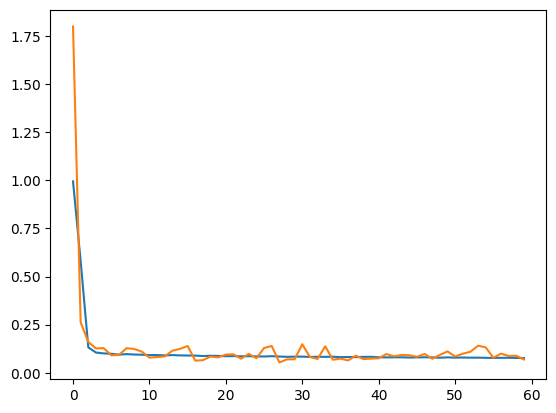

In [71]:
from tqdm import tqdm
from matplotlib import pyplot as plt


# Example
batch_size = 32

input_size = 7
hidden_size = 20
output_size = 1

input_seq_len = 20
output_seq_len = 14
epochs = 60

encoder = Encoder(input_size, hidden_size)
decoder = Decoder(output_size, hidden_size)
model = Seq2Seq(encoder, decoder, output_seq_len)

x = torch.randn(32, input_seq_len, input_size)
y = model(x)
print(y.shape)  # Expected: (32, 7, 6)


optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
criterion = nn.MSELoss()
train_losses = np.zeros(epochs)
val_losses = np.zeros(epochs)

for epoch in tqdm(range(epochs)):
    model.train()
    train_loss = 0.
    count = 0
    for x_batch, y_batch in dataloader_train:
        count += 1
        x_batch = x_batch.type(torch.float32)
        y_batch = y_batch.type(torch.float32)
        # Forward pass
        outputs = model(x_batch)

        loss = criterion(outputs, torch.unsqueeze(y_batch[:, :, -1], axis=2))
        train_loss += loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_losses[epoch] = train_loss / count

    model.eval()
    with torch.inference_mode():
        # 1. Forward pass
        val_loss = 0.
        count = 0
        for x_batch, y_batch in dataloader_val:
            count += 1
            x_batch = x_batch.type(torch.float32)
            y_batch = y_batch.type(torch.float32)
            # Forward pass
            outputs = model(x_batch)

            loss = criterion(outputs, torch.unsqueeze(y_batch[:, :, -1], axis=2))
            val_loss += loss.item()
        
        val_losses[epoch] = val_loss / count

print(train_losses)
plt.plot(train_losses)
plt.plot(val_losses)

# Convolutional Neural Network for Time Series Classification

In [155]:
import pandas as pd

train_data =  pd.read_csv('../Data/ItalyPowerDemand_TRAIN.csv', header=None)
#test_data =  pd.read_csv('../Data/ItalyPowerDemand_TEST.csv', header=None, sep=' ')

In [156]:
y = train_data[0].to_numpy(np.float32)
X = train_data.drop(0, axis=1).to_numpy(np.float32)
X.shape


(67, 24)

In [157]:
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X.astype(float))

In [158]:
X =  torch.from_numpy(X).unsqueeze(1)
X = X.float()
y =  torch.from_numpy(y).squeeze(0)
y = y-1

In [169]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

# Synthetic dataset: 1000 samples, 1 channel, 24 time steps
#X = torch.rand(1000, 1, 24)  # shape: (batch_size, channels, sequence_length)
#y = torch.randint(0, 2, (1000,))  # Binary classification: 2 classes


# Create datasets and loaders
dataset = TensorDataset(X, y)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# CNN model
class TimeSeriesCNN(nn.Module):
    def __init__(self):
        super(TimeSeriesCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3)
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3)
        self.pool2 = nn.MaxPool1d(kernel_size=2)

        # Time dimension: 24 -> 22 -> 11 -> 9 -> 4
        self.flatten_dim = 64 * 4

        self.fc1 = nn.Linear(self.flatten_dim, 64)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 1)  # 2 output classes

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = x.view(-1, self.flatten_dim)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Instantiate model, loss, and optimizer
model = TimeSeriesCNN()
#criterion = nn.CrossEntropyLoss()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(6):
    model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs.squeeze(), batch_y)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

# Evaluation
model.eval()
correct = total = 0
with torch.no_grad():
    for batch_X, batch_y in val_loader:
        outputs = model(batch_X)
        #_, predicted = torch.max(outputs, 1)
        predicted = torch.round(torch.sigmoid(outputs.squeeze()))
        total += batch_y.size(0)
        print(predicted)
        correct += (predicted == batch_y).sum().item()

print(f"Validation Accuracy: {100 * correct / total:.2f}%")

Epoch 1, Loss: 0.6830
Epoch 2, Loss: 0.6593
Epoch 3, Loss: 0.6591
Epoch 4, Loss: 0.6418
Epoch 5, Loss: 0.6290
Epoch 6, Loss: 0.5961
tensor([0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1.])
Validation Accuracy: 92.86%
